In [1]:
import matplotlib.pyplot as plt
from imports import *
import ta_functions as ta

YEARS_OF_DATA = 2
_DAYS = 20

end_date = datetime.now()
start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)

def add_technical_indicators(df):
    df['SMA1'] = df['Close'].rolling(window=int(_DAYS*0.5)).mean()
    df['SMA2'] = df['Close'].rolling(window=_DAYS).mean()
    df['SMA3'] = df['Close'].rolling(window=int(_DAYS*2)).mean()
    df['SMA_Ratio'] = df['SMA1'] / df['SMA2']
    
    df['Bear'] = (df['SMA1'] < df['SMA2']).astype(int)
    df['Bull'] = (df['SMA2'] < df['SMA1']).astype(int)
    df['RSI']= ta.calculate_rsi(df)
    df['RSI_SMA'] = df['RSI'].rolling(14).mean()
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=24, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Upper_Band'] = df['SMA1'] + (2 * df['Close'].rolling(20).std())
    df['Lower_Band'] = df['SMA1'] - (2 * df['Close'].rolling(20).std())
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    df['buy_volume'] = (df.Close > df.Close.shift(1)) * df['Volume']
    df['sell_volume'] = (df.Close < df.Close.shift(1)) * df['Volume']
    df['sumBuyVol'] = df['buy_volume'].rolling(window=20).sum()
    df['sumSellVol'] = df['sell_volume'].rolling(window=20).sum()
    df['vSpike'] = (df['Volume'] > 2 * df['Volume_MA20']).astype(int)
    
    df['CCI'] = ta.calculate_cci(df)
    df['OBV'] = ta.calculate_obv(df)
    df[['+DI', '-DI', 'ADX']] = ta.calculate_dmi(df, n=14)
    df['ATR'] = ta.calculate_atr(high=df.High, low=df.Low, close=df.Close)
    
    df['VWMA'] = ta.calculate_vwma(df)
    df[['KCm', 'KCu', 'KCl']] = ta.calculate_keltner(df)
    df[['VI+', 'VI-']] = ta.calculate_vortex(df)
    df[['STu', 'STl']] = ta.calculate_supertrend(df)
    
    df = ta.add_candlestickpatterns(df)
    
    df['DD'] = df['Close'].where(df['Close'] < df['Close'].shift(1)).std()

    df['return1'] = df['Close'].pct_change(9)
    df['return2'] = df['Close'].pct_change(20)
    df['return3'] = df['Close'].pct_change(50)
    df['Volatility'] = df['Close'].rolling(20).std()
    df = ta.scaled_volatility(df)
    
    return df

In [2]:
def plot_custom_chart(df, ticker):
    # Sort and drop NaNs in critical columns for plotting
    df = df.sort_index()
    df_plot = df.dropna(subset=['Close', 'SMA1', 'SMA2', 'RSI', 'RSI_SMA', 'ADX', 'sumBuyVol', 'sumSellVol'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # --- Price panel ---
    ax1.plot(df_plot.index, df_plot['Close'], color='gray', label='Close', linewidth=1.5)
    ax1.plot(df_plot.index, df_plot['SMA1'], color='orange', label='SMA1', linewidth=1.2)
    ax1.plot(df_plot.index, df_plot['SMA2'], color='red', label='SMA2', linewidth=1.2)

    cond_bull = (df_plot['SMA1'] > df_plot['SMA2']) & (df_plot['Close'] > df_plot['SMA2'])
    cond_bear = (df_plot['SMA1'] < df_plot['SMA2']) & (df_plot['Close'] < df_plot['SMA2'])

    # Fill between SMAs only where both SMA1 and SMA2 are not NaN
    ax1.fill_between(df_plot.index, df_plot['SMA1'], df_plot['SMA2'], where=cond_bull, color='green', alpha=0.18, interpolate=True)
    ax1.fill_between(df_plot.index, df_plot['SMA1'], df_plot['SMA2'], where=cond_bear, color='red', alpha=0.18, interpolate=True)

    ax1.text(0.5, 0.5, ticker, transform=ax1.transAxes,
             fontsize=100, color='gray', alpha=0.25, ha='center', va='center', weight='bold')

    last_close = df_plot['Close'].iloc[-1]
    ax1.annotate(f"${last_close:.2f}", xy=(1, last_close), xycoords=('axes fraction', 'data'),
                 xytext=(-10, 0), textcoords='offset points', ha='right', va='center',
                 fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    ax1.yaxis.tick_right()
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.2)
    
    # Format x-axis dates on top panel
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
 
    # --- RSI panel ---
    x = np.arange(len(df_plot))
    rsi = df_plot['RSI'].values
    rsi_sma = df_plot['RSI_SMA'].values
    
    cond_green = (df_plot['RSI'] > 52) & (df_plot['ADX'] > 22) & (df_plot['sumBuyVol'] > df_plot['sumSellVol'])
    cond_red = (df_plot['RSI'] < 40) & (df_plot['ADX'] > 22) & (df_plot['sumSellVol'] > df_plot['sumBuyVol'])
    
    points_rsi = np.array([x, rsi]).T.reshape(-1, 1, 2)
    segments_rsi = np.concatenate([points_rsi[:-1], points_rsi[1:]], axis=1)
    colors_rsi = np.where(cond_green[:-1], 'green', np.where(cond_red[:-1], 'red', 'gray'))
    lc_rsi = LineCollection(segments_rsi, colors=colors_rsi, linewidths=2, alpha=0.8, label='RSI')
    ax2.add_collection(lc_rsi)
    
    points_rsi_sma = np.array([x, rsi_sma]).T.reshape(-1, 1, 2)
    segments_rsi_sma = np.concatenate([points_rsi_sma[:-1], points_rsi_sma[1:]], axis=1)
    colors_rsi_sma = np.where(cond_green[:-1], 'green', np.where(cond_red[:-1], 'red', 'gray'))
    lc_rsi_sma = LineCollection(segments_rsi_sma, colors=colors_rsi_sma, linewidths=2, alpha=0.5, label='RSI_SMA')
    ax2.add_collection(lc_rsi_sma)
    
    # Add invisible plot to help autoscale
    ax2.plot(x, rsi, alpha=0)
    
    # Set axis limits explicitly
    ax2.set_xlim(x[0], x[-1])
    y_min = min(np.nanmin(rsi), np.nanmin(rsi_sma)) - 5
    y_max = max(np.nanmax(rsi), np.nanmax(rsi_sma)) + 5
    ax2.set_ylim(y_min, y_max)
    
    ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.2)
    ax2.yaxis.tick_right()
    
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    plt.setp(ax2.get_xticklabels(), rotation=45)

    ax1.set_xlim(df_plot.index[0], df_plot.index[-1])
    ax2.set_xlim(df_plot.index[0], df_plot.index[-1])
    
    plt.tight_layout()
    plt.show()

[*********************100%***********************]  1 of 1 completed


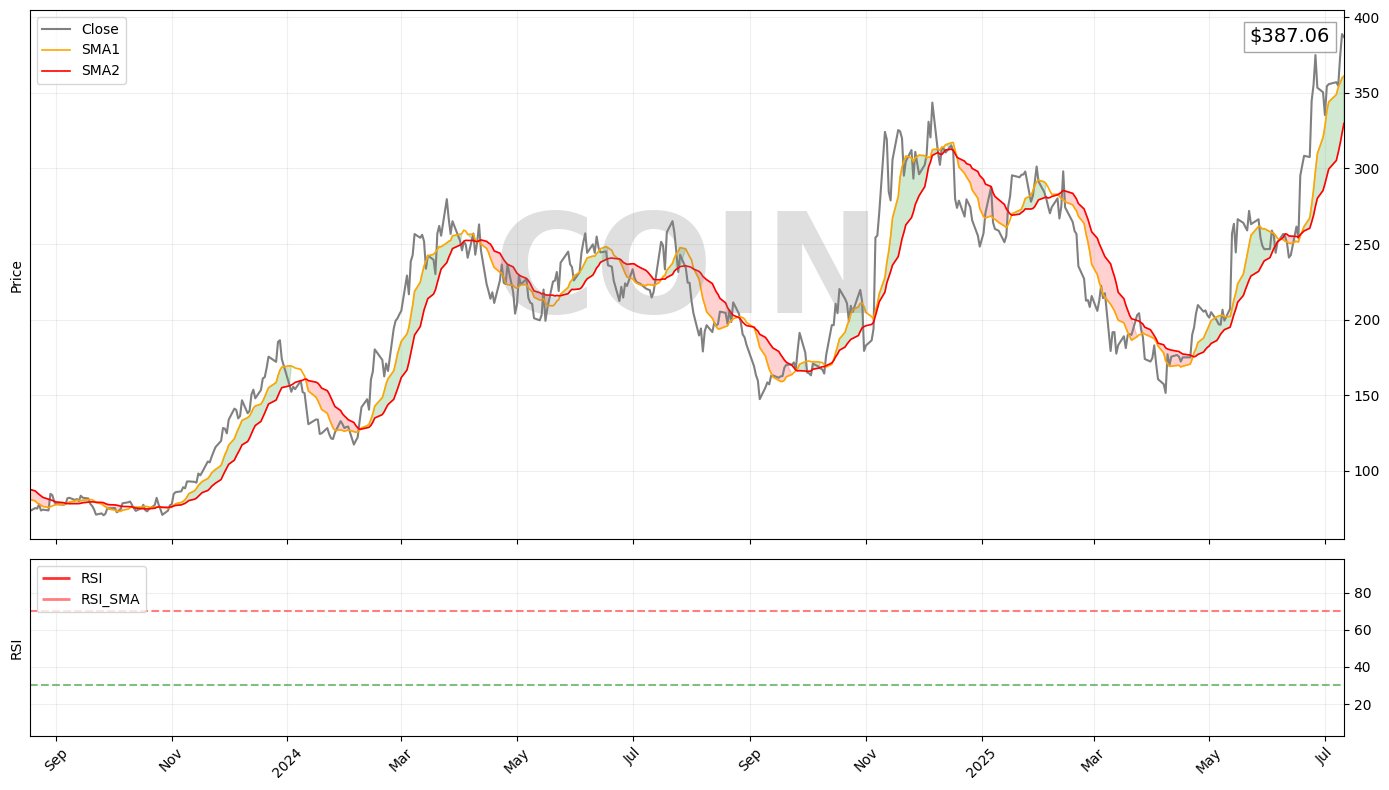

In [3]:
ticker = "COIN"
df = ta.get_stock_data(ticker, start_date, end_date)
df = add_technical_indicators(df)
plot_custom_chart(df, ticker)